In [1]:
import gym
import rospy
import numpy as np
import tensorflow as tf
import tf_agents

from gym.envs.registration import register
from neuroracer_gym import neuroracer_env
from tf_agents.environments import tf_py_environment, utils
from tf_agents.networks import q_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

# just to register env:
from neuroracer_gym.tasks.neuroracer_discrete_task import NeuroRacerTfAgents

None


In [2]:
rospy.init_node('neuroracer_qlearn', anonymous=True, log_level=rospy.INFO)

env = NeuroRacerTfAgents()
env_eval = NeuroRacerTfAgents(val=True)

print('action_spec:', env.action_spec())
print('time_step_spec.observation:', env.time_step_spec().observation)
print('time_step_spec.step_type:', env.time_step_spec().step_type)
print('time_step_spec.discount:', env.time_step_spec().discount)
print('time_step_spec.reward:', env.time_step_spec().reward)

[ERROR] [1609794042.274108, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1609794042.278346, 0.000000]: Start Init ControllersConnection
[WARN] [1609794042.279258, 0.000000]: END Init ControllersConnection
[ERROR] [1609794044.767717, 2.476000]: NOT Initialising Simulation Physics Parameters
[WARN] [1609794044.771566, 2.476000]: Start Init ControllersConnection
[WARN] [1609794044.772484, 2.476000]: END Init ControllersConnection


action_spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
time_step_spec.observation: BoundedArraySpec(shape=(30,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=10.0)
time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')
time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)
time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [3]:
utils.validate_py_environment(env, episodes=1)

Collided, Cumulated Reward: 3, n_steps: 20


In [4]:
time_step = env.reset()

for _ in range(1):
    time_step = env.step(np.array(2, dtype=np.int32))
    print(time_step.reward)

cumulative_reward = time_step.reward

-0.092


In [5]:
print(env.observation_spec())
print(env.action_spec())

BoundedArraySpec(shape=(30,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=10.0)
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)


In [6]:
env = tf_py_environment.TFPyEnvironment(env)
env_eval = tf_py_environment.TFPyEnvironment(env_eval)

In [7]:
fc_layer_params = (128, )
dropout_layer_params = (None, )

q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec())

In [8]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    n_step_update=1,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

print(env.batch_size)
print(agent.collect_data_spec)

1
Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(30,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(10., dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [9]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

In [10]:
time_step = env.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>, state=(), info=())

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

compute_avg_return(env, random_policy, 2)

Collided, Cumulated Reward: 19, n_steps: 73
Collided, Cumulated Reward: 4, n_steps: 18


-88.63335

In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=100000)

In [13]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(30,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(10., dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [14]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [15]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(env, random_policy, replay_buffer, 100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

Collided, Cumulated Reward: 6, n_steps: 25
Collided, Cumulated Reward: 10, n_steps: 20


In [16]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=1, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(1, 2), observation=(1, 2, 30), action=(1, 2), policy_info=(), next_step_type=(1, 2), reward=(1, 2), discount=(1, 2)), BufferInfo(ids=(1, 2), probabilities=(1,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [17]:
iterator = iter(dataset)

print(iterator)

In [ ]:
import pylab as pl
from IPython import display

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy, 2)
returns = [avg_return]
losses = []
steps_run = []
step_count = 0
print("Starting training... ")
for _ in range(50000):
    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(env, agent.collect_policy, replay_buffer, 1)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    
    if step % 1 == 0:
        losses.append(train_loss.numpy())

    if step % 100 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        
    if step % 2500 == 0:
        avg_return = compute_avg_return(env, agent.policy, 2)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

In [20]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

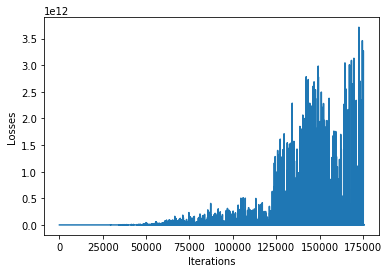

In [27]:
iterations = range(0, 10000 + 1, 1)
plt.plot(losses)
plt.ylabel('Losses')
plt.xlabel('Iterations')
#plt.ylim(top=10)

Text(0.5, 0, 'Iterations')

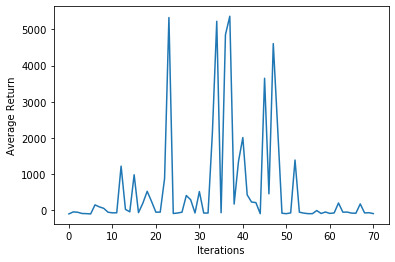

In [28]:
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [ ]:
for _ in range(1000):
    experience_replay.timestamp_data(env, agent.collect_policy)

In [ ]:

        
        # five_secs_ago = self.timer2 - rospy.Duration(5) # Time minus Duration is a Time
        if time.time() - self.timer2 > 30.0:
            if self._get_distance(self.last_pos, self._get_pos_x_y()) < 1.2:
                print('new break after: {}'.format(self._get_distance(self.last_pos, self._get_pos_x_y())))
                self._episode_ended = True
                if self.val:
                    reward = self._compute_dist_from_origin()
                else:
                    reward = -10.
                return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
            else:
                self.last_pos = self._get_pos_x_y()
            self.timer2 = time.time()

#### 